<a href="https://colab.research.google.com/github/mcppp/FinalProjectI2DL/blob/main/IMAGE_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Importing Images from a custom dataset into Pytorch
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import StepLR

print(torch.__version__)

1.7.1


In [ ]:
data_path = './FER2013' #where to find dataset, modify path as needed
model_dir = './models'  #where to save models, modify path as needed 

In [ ]:
class FERdataset(Dataset):
    def __init__(self, data_path, is_training):
        self.data_path = data_path
        self.train_path = os.path.join(data_path, 'train') #directory path for train set
        self.val_path = os.path.join(data_path, 'validate') #directory path for validation set
        self.is_training = is_training
        if self.is_training:  #based on flag is_training, the target_path will be assigned
            self.target_path = self.train_path
        else:
            self.target_path = self.val_path

        self.classes = sorted(os.listdir(self.target_path)) #sorted list of classes available in target_path directory
        self.img_path_label = list() #creating empty list 
        for c in self.classes: #for all classes found in directory
            img_list = os.listdir(os.path.join(self.target_path, c)) #list of img names found in target_path/c with c being the name of each class
            for fp in img_list: #for each img in each class folder
                full_fp = os.path.join(self.target_path, c, fp)  #save full path of each image
                self.img_path_label.append((full_fp, c, self.classes.index(c))) #fill/make list of full file path of img, class name, index of class required to train nn
        
      
        self.tensor_transform = torchvision.transforms.ToTensor() #converst img to tensor type
               
    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)  #make original img into tensor

        inputs = self.tensor_transform(img) #applying defined transformations to validation data
            
        sample = dict()   #creating dict
        sample['input'] = inputs #our transformed image
        sample['original_img'] = original_img  #original image
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

In [ ]:
train_dataset = FERdataset(data_path, True)
val_dataset = FERdataset(data_path, False)

len(val_dataset)

7178

In [ ]:
torch.manual_seed(0)
val_set, test_set = torch.utils.data.random_split(val_dataset, [3589, 3589])

In [ ]:
batch_size = 64


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True) #DataLoader is for batching, etc. (sampling)

val_dataloader = DataLoader(val_set, batch_size=1, shuffle=False, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

num_classes = 7

In [ ]:
sample = next(iter(train_dataloader)) #providing us with one training sample

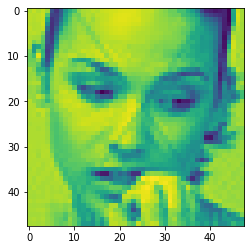

In [ ]:
imgplot = plt.imshow(sample['input'][0].squeeze())
plt.show()

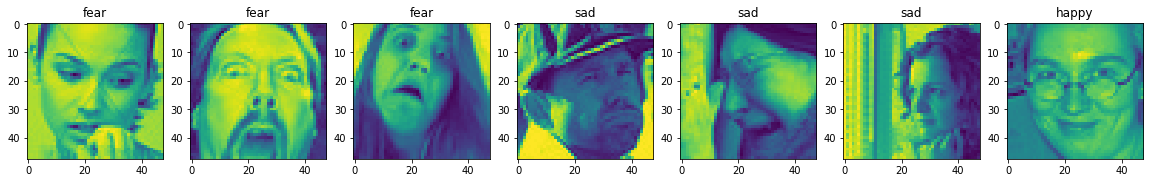

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].squeeze())
    ax[i].set_title(sample['class_name'][i])
 

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


In [ ]:
class Model(nn.Module): 
    def __init__(self, feat_dim = 2048, dim_output=7):
        super(Model, self).__init__()

        self.feat_dim = feat_dim #dim of feature after getting flattened into a vector (we check this, we do not know it in advance)
        self.dim_output = dim_output #output dimension = number of classes
        

        ###################################### PRE-TRAINED MODEL ###########################################
        self.backbone = torchvision.models.resnet152(pretrained=True) #download model that's already been trained based on image classification problem
        
        for p in list(self.backbone.children())[:-1]:
            p.requires_grad = False  #parameters of layers inside list in line above become fixed
                                     #True: parameter will be trained, False: parameter won't be trained, frozen
          
        # # # get the structure until the Fully Connected Layer
        modules = list(self.backbone.children())[:-1]  #list of all layers except last one (the fc one)
        self.backbone = nn.Sequential(*modules) #put list into nn mode, not just a list -> this is our new model without last layer

        
        ######################################## DEFINING MY NEW LAYERS ####################################################
        self.fc1 = nn.Linear(feat_dim, feat_dim//2) # 2048 -> 1024 
                                                    # we know input has to be 2048 because that was the input of the fc we deleted from pre-trained model
        self.fc2 = nn.Linear(feat_dim//2, feat_dim//4) # 1024 -> 512
        self.fc3 = nn.Linear(feat_dim//4, dim_output) # 512 -> 7 must be the output dim, it is the number of classes (pokemon types)
       
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU(0.1, inplace=True)

        
        ######################################## STRUCTURE OF FINAL MODEL ####################################################

    def forward(self, img):  
        batch_size = img.shape[0] # it is the previously defined batch_size, which is the first dim of the image
        out = self.backbone(img) # torch.Size([64, 2048, 1, 1])
        # print(out.shape)
                                 # get the feature from the pre-trained resnet
                                 # this gets output of pre-trained resnet (excluding last layer fc that we took out, so now dim is 2048)
       
        out = out.view(batch_size, -1)      
        out = self.fc1(out) 
        out = self.dropout(self.relu(out)) 
        out = self.fc2(out) 
        out = self.dropout(self.relu(out)) 
        out = self.fc3(out) 

        return out

In [ ]:
model = Model() # creating model
model = model.to(device) # to train on GPU

optimizer = optim.AdamW(model.parameters(), lr=1e-4) #defining optimizer

In [ ]:
# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
def train(model, optimizer, sample):  #Only defined for one batch????
    
    model.train() # setting training mode

    criterion = nn.CrossEntropyLoss() #loss function (CrossEntropy convenient when training for many classes)

    optimizer.zero_grad() # setting gradients to zero before starting backpropagation (PyTorch accumulates the gradients on subsequent backward passes)

    inp = np.repeat(sample['input'].squeeze()[..., np.newaxis], 3, -1)
 
    input = inp.permute(0,3,1,2).float().to(device) # our transformed image batch; torch.Size([64, 3, 224, 224])
    target = sample['target'].long().to(device) # class label batch; torch.Size([64])
    
    pred = model(input) # each should give: torch.Size([64, 18])

    pred_loss = criterion(pred, target) # calculate prediction loss for one batch, should be of size 64
    
    top3_val, top3_idx = torch.topk(pred, 3) 
    
    num_correct = torch.sum(top3_idx == target.view(-1, 1))     
    
    
    reg_loss = 0.0
    for p in model.parameters(): #iterate parameters inside the model
       if p.requires_grad: #this parameter is the trainable parameter
         reg_loss += torch.norm(p, 2)  #norm 2, this is regularization loss
    total_loss = pred_loss + 1e-6 * reg_loss
    
    
    
    total_loss.backward() 
    
    optimizer.step() 
    
    return pred_loss.item(), num_correct.item()

In [ ]:
def validate(model, sample):
    model.eval()  #turning on evaluatino time

    criterion = nn.CrossEntropyLoss() #loss function

    with torch.no_grad(): # turning off gradient computation when we know we won't call tensor.backward()
                          
        inp = np.repeat(sample['input'].squeeze()[..., np.newaxis], 3, -1)
        inp = torch.Tensor(inp)
        inp = torch.unsqueeze(inp, 0)
        inp = inp.permute(0,3,1,2)        
       
        input=inp.float().to(device) 
        target = sample['target'].long().to(device)

        pred = model(input)
        pred_loss = criterion(pred, target)

        top3_val, top3_idx = torch.topk(pred, 3)

        num_correct = torch.sum(top3_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item(), pred

In [ ]:
##Creating empty lists to save variables for plotting later
val_list =list()
train_list =list()
epochs_list = list()

In [ ]:
# ##RUNING TRAINING
# max_epoch = 200   #how many times the whole dataset will be trained
# save_stride = 10
# tmp_path = './checkpoint.pth'
# max_accu = -1
# for epoch in tqdm(range(max_epoch)):   
    
    
   
#     ################################################### TRAIN PHASE ########################################################
    
#     # Initialize Loss and Accuracy
#     train_loss = 0.0
#     train_accu = 0.0

#     # Iterate over the train_dataloader
#     with tqdm(total=len(train_dataloader)) as pbar: # SUB PROGRESS BAR 1 / total=46 is the amount of batches made when choosing batch_size=64
#         for idx, sample in enumerate(train_dataloader):  #for each of the 46 batches of images when batch_size is 64
#             curr_loss, num_correct = train(model, optimizer, sample)  #call train and save current pred_loss and num_correct
#             train_loss += curr_loss / len(train_dataloader) #average of training loss (loss of each batch / amount of batches)
#             train_accu += num_correct / len(train_dataset)  #average of training accuracy (correct predicitions / amount of total images)
#             pbar.update(1) #update SUB PROGRESS BAR 1 progress bar every time a batch is trained
            
#     # Decay Learning Rate
#     scheduler.step()

#     # save the model and optimizer's information before the evaulation
#     checkpoint = {   #DO NOT MODIFY
#         'model' : Model(),
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }
    
    
#     ################################################### VALIDATION PHASE ########################################################

#     # Initialize Loss and Accuracy
#     val_loss = 0.0
#     val_accu = 0.0

#     # Iterate over the val_dataloader
#     with tqdm(total=len(val_dataloader)) as pbar: # SUB PROGRESS BAR 2, up to 586 because that's the number of images in the 1 batch of val_dataloader
#         for idx, sample in enumerate(val_dataloader): # for each of the 586 images
#             curr_loss, num_correct,_ = validate(model, sample)
#             val_loss += curr_loss / len(val_dataloader) # average validation loss
#             val_accu += num_correct / len(val_dataloader) # average accuracy
#             pbar.update(1) # update SUB PROGRESS BAR 2



#     max_accu = max(val_accu, max_accu) #keep updating max accuracy reached
#     if max_accu == val_accu: #if max accuracy is the current one, save this model
#         # Save your best model to the checkpoint
#         torch.save(checkpoint, os.path.join(model_dir, 'face_11.pth'))

   
#     train_list.append(train_accu)
#     val_list.append(val_accu)
#     epochs_list.append(epoch)

#     print(train_accu, val_accu)


0.7984255808283135 0.8670938980217219



0.8973492632972256 0.8918918918918803



0.942909888885016 0.8885483421565781



0.9688947716743859 0.8991362496517019



0.9920582395764368 0.9055447199776979



0.9961336166358961 0.8963499582056167


KeyboardInterrupt: 

In [ ]:
#Lodaing saved model
best_path=torch.load('./models/face_11.pth')
model.load_state_dict(best_path['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Reporting on test set
test_loss = 0.0
test_accu = 0.0

    # Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar: # SUB PROGRESS BAR 2, up to 586 because that's the number of images in the 1 batch of val_dataloader
    for idx, sample in enumerate(test_dataloader): # for each of the 586 images
            curr_loss, num_correct,_ = validate(model, sample)
            test_loss += curr_loss / len(test_dataloader) # average validation loss
            test_accu += num_correct / len(test_dataloader) # average accuracy
            pbar.update(1) # update SUB PROGRESS BAR 2
            
print(test_loss, test_accu)


1.2688768197668117 0.9077737531345661


In [ ]:
print('Accuracy reported on unseen test set: ', test_accu)

Accuracy reported on unseen test set:  0.9077737531345661


In [ ]:
##Creating confusion matrix based on test set
nb_classes = 7
predictions= np.zeros(len(test_set))
labels= np.zeros(len(test_set))

with tqdm(total=len(test_dataloader)) as pbar:
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for idx, sample in enumerate(test_dataloader):
            labels[idx]=sample['target'].item()
            _, _, outputs = validate(model, sample)
            _, preds = torch.max(outputs, 1)
            predictions[idx] = preds
            for t, p in zip(sample['target'].view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            pbar.update(1) # update SUB PROGRESS BAR 2

print(confusion_matrix)


tensor([[274.,   2.,  54.,  24.,  48.,  84.,  10.],
        [  6.,  28.,   4.,   2.,   3.,   4.,   1.],
        [ 47.,   0., 244.,  16.,  31., 116.,  33.],
        [ 18.,   1.,  18., 744.,  38.,  43.,  19.],
        [ 32.,   0.,  44.,  48., 370., 129.,   1.],
        [ 63.,   3., 101.,  33.,  92., 349.,   6.],
        [ 10.,   0.,  39.,  24.,  12.,   7., 314.]])


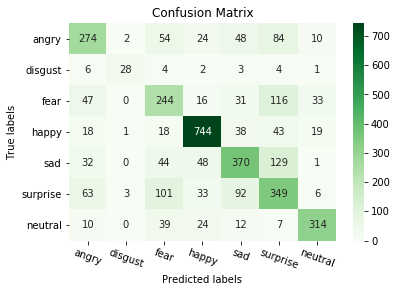

In [ ]:
##Plotting confusion matrix as seaborn heatmap

import seaborn as sns    

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax = ax,fmt='g',cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
plt.yticks(rotation=0)
plt.xticks(rotation=-20)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["angry","disgust","fear","happy", "sad","surprise","neutral"]); ax.yaxis.set_ticklabels(["angry","disgust","fear","happy", "sad","surprise","neutral"]);

(6,)
(6,)
(6,)


Text(0.5, 1.0, 'Train vs. Validation accuracy')

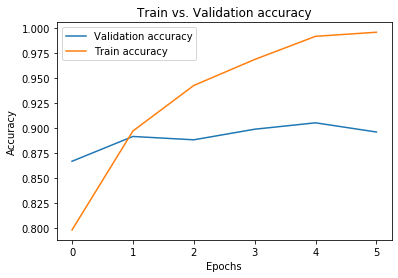

In [ ]:
##Plotting train vs. validation accuracy curve
arr_epochs =np.array(epochs_list)
arr_val =np.array(val_list)
arr_train = np.array(train_list)
print(arr_epochs.shape)
print(arr_val.shape)
print(arr_train.shape)


f = plt.figure()
ax = f.add_subplot(111)
ax.plot(arr_epochs, arr_val,  label="Validation accuracy")
ax.plot(arr_epochs, arr_train,  label="Train accuracy")
ax.legend()

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs. Validation accuracy')